In [ ]:
#Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
#Mount google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Load dataset

In [3]:
img_height, img_width = 224, 224
batch_size = 32

train_dir = "/content/drive/MyDrive/Tumour-20250719T154752Z-1-001/Tumour/train"
val_dir = "/content/drive/MyDrive/Tumour-20250719T154752Z-1-001/Tumour/valid"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=10
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1702 images belonging to 4 classes.
Found 502 images belonging to 4 classes.


In [ ]:
#Build custom CNN model

In [4]:
# Define input shape
input_shape = (img_height, img_width, 3)

# Define number of tumor categories
num_classes = train_data.num_classes

# Build the model
cnn_model = Sequential()

# Block 1
cnn_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))

# Block 3
cnn_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.4))

# Flatten and Fully Connected Layers
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

# Output layer
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,356 (49.36 MB)

 Trainable params: 12,939,652 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
#Train custom CNN

In [6]:
# Define Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_custom_cnn_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

# Train the model
history_cnn = cnn_model.fit(
    train_data,
    epochs=5,
    validation_data=val_data,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/5
33/54 ━━━━━━━━━━━━━━━━━━━━ 2:31 7s/step - accuracy: 0.7816 - loss: 0.6025

KeyboardInterrupt: 

In [ ]:
#Transfer Learning with ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base layers

model_resnet = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_data.num_classes, activation='softmax')
])

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

history_resnet = model_resnet.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    callbacks=[early_stop, ModelCheckpoint("best_resnet_model.h5", save_best_only=True)]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,500 (90.98 MB)

 Trainable params: 262,788 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.2849 - loss: 1.6004

54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 926ms/step - accuracy: 0.2859 - loss: 1.5972 - val_accuracy: 0.4263 - val_loss: 1.2295
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.4165 - loss: 1.2578

54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 658ms/step - accuracy: 0.4164 - loss: 1.2578 - val_accuracy: 0.5040 - val_loss: 1.1916
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.4520 - loss: 1.2415

54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 674ms/step - accuracy: 0.4523 - loss: 1.2411 - val_accuracy: 0.4861 - val_loss: 1.1343
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.4911 - loss: 1.1889

54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 699ms/step - accuracy: 0.4908 - loss: 1.1890 - val_accuracy: 0.6295 - val_loss: 1.1000
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.4819 - loss: 1.1801

54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 698ms/step - accuracy: 0.4822 - loss: 1.1797 - val_accuracy: 0.4861 - val_loss: 1.0909
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.5075 - loss: 1.1362

54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 656ms/step - accuracy: 0.5075 - loss: 1.1363 - val_accuracy: 0.6454 - val_loss: 1.0434
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4991 - loss: 1.1672

54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 676ms/step - accuracy: 0.4995 - loss: 1.1666 - val_accuracy: 0.6016 - val_loss: 1.0238
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.5302 - loss: 1.1306

54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 679ms/step - accuracy: 0.5304 - loss: 1.1303 - val_accuracy: 0.6633 - val_loss: 1.0119
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.5403 - loss: 1.1045

54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 677ms/step - accuracy: 0.5405 - loss: 1.1042 - val_accuracy: 0.6434 - val_loss: 0.9987
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.5439 - loss: 1.0783

54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 691ms/step - accuracy: 0.5441 - loss: 1.0782 - val_accuracy: 0.6673 - val_loss: 0.9743
Restoring model weights from the end of the best epoch: 10.


In [ ]:
#Model Evaluation

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.33      0.52      0.41       161
  meningioma       0.31      0.07      0.12       124
    no_tumor       0.18      0.19      0.19        99
   pituitary       0.22      0.22      0.22       118

    accuracy                           0.27       502
   macro avg       0.26      0.25      0.23       502
weighted avg       0.27      0.27      0.25       502



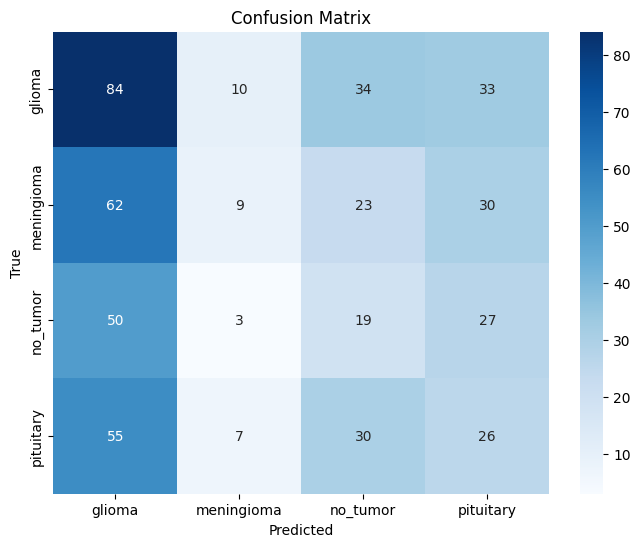

In [ ]:
# Get true labels and predicted labels
val_data.reset()
y_true = val_data.classes
y_pred_probs = model_resnet.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Get class labels
class_labels = list(val_data.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

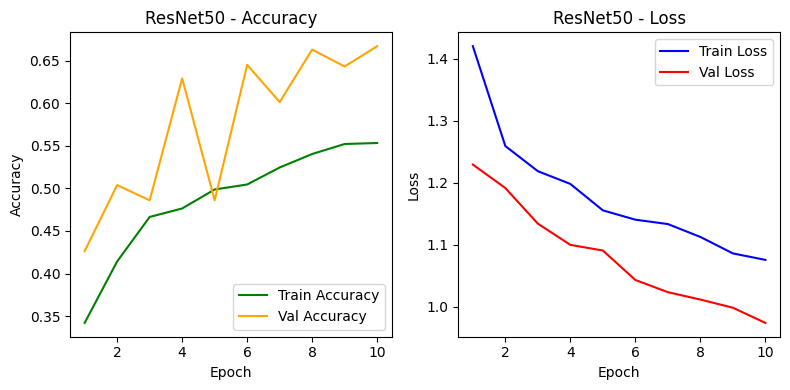

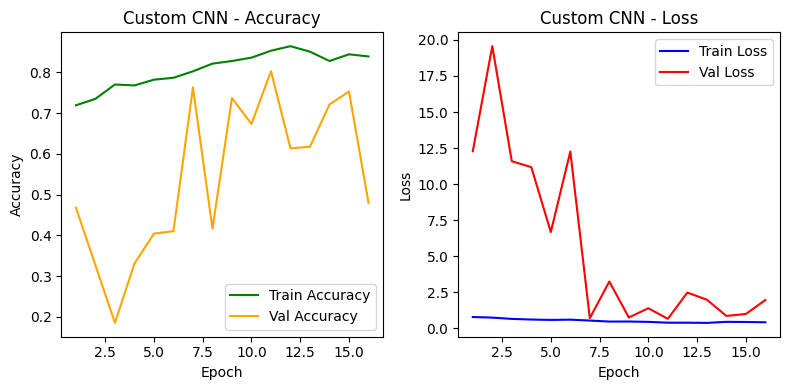

In [ ]:
def plot_history(history, title='Model'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1) # Corrected to get the number of epochs from history

    plt.figure(figsize=(8, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy', color='green')
    plt.plot(epochs_range, val_acc, label='Val Accuracy', color='orange')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Val Loss', color='red')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history_resnet, title='ResNet50')
plot_history(history_cnn, title='Custom CNN')

In [ ]:
#Model Comparison

In [ ]:
val_loss, val_acc = model_resnet.evaluate(val_data)
print(f"ResNet50 Validation Accuracy: {val_acc*100:.2f}%")

val_loss_cnn, val_acc_cnn = cnn_model.evaluate(val_data)
print(f"Custom CNN Validation Accuracy: {val_acc_cnn*100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.6631 - loss: 1.0082
ResNet50 Validation Accuracy: 66.73%
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.8042 - loss: 0.6474
Custom CNN Validation Accuracy: 80.28%


In [ ]:
# Custom CNN model is the best model

In [8]:
import os
save_path = '/content/drive/MyDrive/brain_tumor_models'
os.makedirs(save_path, exist_ok=True)

In [9]:
import shutil
shutil.move('best_custom_cnn_model.h5', f'{save_path}/best_custom_cnn_model.h5')

'/content/drive/MyDrive/brain_tumor_models/best_custom_cnn_model.h5'

In [10]:
!pip install streamlit streamlit_option_menu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00


In [11]:
%%writefile Tumor.py

Writing Tumor.py


In [20]:
%%writefile Tumor.py
import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the trained model
model = load_model(r"/content/drive/MyDrive/brain_tumor_models/best_custom_cnn_model.h5")

# Define class names
class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

st.title("🧠 Brain Tumor MRI Classification")
st.write("📤 Upload an MRI image to predict the tumor type.")

# Upload image
uploaded_file = st.file_uploader("Choose an MRI image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    st.image(uploaded_file, caption='Uploaded MRI Image', use_container_width=True)

    # Preprocess the image
    img = load_img(uploaded_file, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    class_name = class_names[class_index]
    confidence = np.max(prediction)

    st.success(f"🧾 **Prediction**: {class_name} ({confidence * 100:.2f}%)")

Overwriting Tumor.py


In [21]:
!wget -q -O - ipv4.icanhazip.com

35.224.243.68


In [ ]:
! streamlit run Tumor.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.224.243.68:8501

⠧⠇⠏⠋⠙⠹⠸your url is: https://social-women-share.loca.lt
2025-07-21 08:14:11.090355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753085651.118181   15389 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753085651.126795   15389 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-21 08:14:17.185570: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
1/1 ━━━━━━━━━━━━━━